<a href="https://colab.research.google.com/github/rcb2021/ET5003_SEM1_2021-2/blob/main/ET5003_Etivity2_RayBeechinor_20201214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '2021-09-25' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20201214" #@param {type:"string"}
Student_full_name = "Ray Beechinor" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

In [6]:
# to plot
import matplotlib.colors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [7]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

In [8]:
# Mount Google drive
bInColab=True
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    bInColab=False
print("Colab Status: {}".format(bInColab))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Colab Status: True


## Training & Test Data

In [9]:
# path to your Google Drive
if bInColab is True:
    pathDrive = '/content/drive/MyDrive/HousePrices/'
else:
    pathDrive = './'

In [10]:
sTrainingFile = "house_train.csv"
sTestFile     = "house_test.csv"
sCostFile     = "true_price.csv"

sTrainingFilePath = "{}{}".format(pathDrive,sTrainingFile)
sTestFilePath     = "{}{}".format(pathDrive,sTestFile)
sCostFilePath     = "{}{}".format(pathDrive,sCostFile)

# load training dataset
dftrain = pd.read_csv(sTrainingFilePath)

dftest = pd.read_csv(sTestFilePath)

dfcost = pd.read_csv(sCostFilePath)


# **Some initial data exploration**
### 1. Check the contents of the 'dftrain' data frame


In [11]:
dftrain.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


### 2. Look at numerical data in the frame




In [12]:
dftrain.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


### 3. Coarse information about data types and number of entries in each column

In [13]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2982 entries, 0 to 2981
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ad_id               2982 non-null   int64  
 1   area                2982 non-null   object 
 2   bathrooms           2931 non-null   float64
 3   beds                2931 non-null   float64
 4   ber_classification  2305 non-null   object 
 5   county              2982 non-null   object 
 6   description_block   2982 non-null   object 
 7   environment         2982 non-null   object 
 8   facility            965 non-null    object 
 9   features            2982 non-null   object 
 10  latitude            2982 non-null   float64
 11  longitude           2982 non-null   float64
 12  no_of_units         59 non-null     float64
 13  price               2892 non-null   float64
 14  property_category   2982 non-null   object 
 15  property_type       2931 non-null   object 
 16  surfac

In [14]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ad_id               500 non-null    int64  
 1   area                500 non-null    object 
 2   bathrooms           500 non-null    float64
 3   beds                500 non-null    float64
 4   ber_classification  444 non-null    object 
 5   county              500 non-null    object 
 6   description_block   500 non-null    object 
 7   environment         500 non-null    object 
 8   facility            189 non-null    object 
 9   features            500 non-null    object 
 10  latitude            500 non-null    float64
 11  longitude           500 non-null    float64
 12  no_of_units         0 non-null      float64
 13  property_category   500 non-null    object 
 14  property_type       500 non-null    object 
 15  surface             500 non-null    float64
dtypes: float

In [15]:
dfcost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        500 non-null    int64  
 1   Expected  500 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.9 KB



### 4. Number of missing entries in features



In [16]:
dftrain.isna().sum()

ad_id                    0
area                     0
bathrooms               51
beds                    51
ber_classification     677
county                   0
description_block        0
environment              0
facility              2017
features                 0
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

In [17]:
dftest.isna().sum()

ad_id                   0
area                    0
bathrooms               0
beds                    0
ber_classification     56
county                  0
description_block       0
environment             0
facility              311
features                0
latitude                0
longitude               0
no_of_units           500
property_category       0
property_type           0
surface                 0
dtype: int64

### 5. Categorical data

In [18]:
# Identify categorical and numerical data - see https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical/29803290#29803290
def getCategoricalAndNumericalFeatures(df):
    """Given a Pandas dataframe, 'df', print the list of columns in that dataframe containing categorical data.
    Returns a dictionary with two keys:
    key 'categorical': returns a list of categorical features
    key 'numerical' : returns a list of numerical features
    """
    dReturnDict = {}
    cols = df.columns
    numCols = df._get_numeric_data().columns
    # Return a list of the columns containing categorical data
    # this assumes that every column which is not numeric is categorical
    # OK for this dataset, but may not generally hold.
    lCategorical = list(set(cols) - set(numCols))
    lOriginalNumerical = list(set(numCols))
    sCategories = ",".join(lCategorical)
    print("Categorical data in this dataset are: {}".format(sCategories))
    dReturnDict['categorical'] = lCategorical
    dReturnDict['numerical'] = lOriginalNumerical
    return dReturnDict

In [19]:
# Again, useful for this task to summarise the categorical data:
# Create a data frame of the categorical data, generate some stats using 'describe'
dFeatureDict = getCategoricalAndNumericalFeatures(dftrain)

dfCategorical = dftrain[dFeatureDict['categorical']]
dfCategorical.describe()

Categorical data in this dataset are: description_block,environment,property_category,county,facility,ber_classification,property_type,features,area


,description_block,environment,property_category,county,facility,ber_classification,property_type,features,area
count,2982,2982,2982,2982,965,2305,2931,2982,2982
unique,2978,1,2,1,34,16,10,1882,156
top,O'Connor Estate Agents are honoured to present...,prod,sale,Dublin,"Parking,Gas Fired Central Heating",D1,apartment,None,Finglas
freq,2,2982,2923,2982,184,283,759,1095,94


In [20]:
dftrain['county'].value_counts()

Dublin    2982
Name: county, dtype: int64

In [21]:
dftrain['environment'].value_counts()

prod    2982
Name: environment, dtype: int64

In [22]:
dftrain['area'].unique()

array(['Portmarnock', 'Lucan', 'Rathfarnham', 'Balbriggan', 'Foxrock',
       'Blackrock', 'Templeogue', 'Ballyboughal', 'Ballycullen',
       'Cabinteely', 'Glasnevin', 'Skerries', 'Clongriffin', 'Clonee',
       'Killiney', 'Newcastle', 'Donabate', 'Dublin 2', 'Lusk',
       'Clondalkin', 'Rathgar', 'Glenageary', 'Goatstown',
       'Dun Laoghaire', 'Howth', 'Castleknock', 'Citywest', 'Malahide',
       'Swords', 'Rush', 'Shankill', 'Stepaside', 'Donaghmede',
       'Dublin 4', 'Baldoyle', 'Ranelagh', 'Carrickmines', 'Rathmichael',
       'Loughshinny', 'Finglas', 'Dublin 1', 'Ballsbridge', 'Sandycove',
       'Dalkey', 'Dublin 8', 'Booterstown', 'Ballymun', 'Navan Road (D7)',
       'Cabra', 'Garristown', 'Rialto', 'Drumcondra', 'Clontarf',
       'Dundrum', 'Donnybrook', 'Santry', 'Blanchardstown', 'Sandyford',
       'Palmerstown', 'Sandymount', 'Terenure', 'Crumlin', 'Saggart',
       'Mulhuddart', 'Whitehall', 'Walkinstown', 'Christchurch',
       'Clonskeagh', 'Phibsborough', '

Commentary: all locations appear to be in the Dublin area

In [23]:
print("Min longitude training = {}".format(dftrain.longitude.min()))
print(dftrain[dftrain.longitude == dftrain.longitude.min()])
print("Max longitude = {}".format(dftrain.longitude.max()))
print(dftrain[dftrain.longitude == dftrain.longitude.max()])
print("Max latitude = {}".format(dftrain.latitude.max()))
print(dftrain[dftrain.latitude == dftrain.latitude.max()])
print("Min latitude = {}".format(dftrain.latitude.min()))
print(dftrain[dftrain.latitude == dftrain.latitude.min()])

Min longitude training = -6.5211830000000015
        ad_id       area  bathrooms  ...  property_category property_type surface
492  12173209  Newcastle        4.0  ...               sale      bungalow   210.0

[1 rows x 17 columns]
Max longitude = -1.744995
        ad_id        area  bathrooms  ...  property_category  property_type surface
767  12270559  Clondalkin        1.0  ...               sale  semi-detached    79.0

[1 rows x 17 columns]
Max latitude = 53.630588
         ad_id        area  bathrooms  ...  property_category property_type surface
1477  12375974  Balbriggan        4.0  ...               sale      detached   641.0

[1 rows x 17 columns]
Min latitude = 51.4584386
        ad_id        area  bathrooms  ...  property_category  property_type surface
861  12283542  Glenageary        2.0  ...               sale  semi-detached     NaN

[1 rows x 17 columns]


In [24]:
print("Min longitude test = {}".format(dftest.longitude.min()))
print(dftest[dftest.longitude == dftest.longitude.min()])
print("Max longitude = {}".format(dftest.longitude.max()))
print(dftest[dftest.longitude == dftest.longitude.max()])
print("Max latitude = {}".format(dftest.latitude.max()))
print(dftest[dftest.latitude == dftest.latitude.max()])
print("Min latitude = {}".format(dftest.latitude.min()))
print(dftest[dftest.latitude == dftest.latitude.min()])

Min longitude test = -6.4969869076382984
       ad_id       area  bathrooms  ...  property_category property_type surface
52  12046807  Rathcoole        4.0  ...               sale      detached   362.0

[1 rows x 16 columns]
Max longitude = -6.064874
        ad_id   area  bathrooms  ...  property_category  property_type surface
100  12268641  Howth        3.0  ...               sale  semi-detached   319.9

[1 rows x 16 columns]
Max latitude = 53.619775
        ad_id        area  bathrooms  ...  property_category property_type surface
201  12384166  Balbriggan        2.0  ...               sale     apartment    71.0

[1 rows x 16 columns]
Min latitude = 53.221348490789005
       ad_id         area  bathrooms  ...  property_category property_type surface
84  12243993  Rathmichael        3.0  ...               sale      detached   320.0

[1 rows x 16 columns]


**Commentary**
1.  We have 2982 examples
2.  The features 'facility' and 'no_of_units' have many empty values
3.  We have seven (7) numerical features, including 'price' which is our target label
4.  Some features convey no additional useful information:  'area' is text indicating location, as is 'county'. However, 'latitude' and 'longitude' convey essentially the same information, in finer detail
5.  Outliers:  The 'beds', 'bathrooms', and 'surface' features appear to contain outliers: all three have maximum values far greater than the 75% mark, and 'surface' has a minimum value far below the 25% mark.

In [25]:
# 1. Start by dropping 'ad_id', as this is just a sequential key
#dftrain.drop('ad_id', axis=1, inplace=True) # axis=1 => dropping a column
# 2. Drop no_uf_units column as it's mostly empty
dftrain.drop('no_of_units', axis=1, inplace=True)
dftest.drop('no_of_units', axis=1, inplace=True)
# 3. Drop facility column as it's also mostly empty
dftrain.drop('facility', axis=1, inplace=True)
dftest.drop('facility', axis=1, inplace=True)

In [26]:
# 4. Drop 'environment' as it has only one value
dftrain.drop('environment', axis=1, inplace=True)
dftest.drop('environment', axis=1, inplace=True)
# 5. Drop 'county': only one value (Dublin)
dftrain.drop('county', axis=1, inplace=True)
dftest.drop('county', axis=1, inplace=True)
# 6. Drop 'area' as it's covered implicitly by latitude and longitude
dftrain.drop('area', axis=1, inplace=True)
dftest.drop('area', axis=1, inplace=True)
# 7. Drop 'description_block' as it's freeform text
dftrain.drop('description_block', axis=1, inplace=True)
dftest.drop('description_block', axis=1, inplace=True)

In [27]:
dCategoricalAndNumericalFeatures = getCategoricalAndNumericalFeatures(dftrain)
lCategoricalFeatures = dCategoricalAndNumericalFeatures['categorical']
for sCategoricalFeature in lCategoricalFeatures:
  print("Feature: '{}'".format(sCategoricalFeature))
  print("\t{}".format(dftrain[sCategoricalFeature].value_counts()))
  print("\n")

Categorical data in this dataset are: property_type,features,property_category,ber_classification
Feature: 'property_type'
	apartment         759
semi-detached     754
terraced          554
detached          398
end-of-terrace    237
bungalow           84
duplex             60
site               55
townhouse          27
studio              3
Name: property_type, dtype: int64


Feature: 'features'
	None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

### Commentary
Drop 'features' as it is free-form text

In [28]:
dftrain.drop('features', axis=1, inplace=True)
dftest.drop('features', axis=1, inplace=True)

In [29]:
# Check the number of missing values again
dftrain.isna().sum()

ad_id                   0
bathrooms              51
beds                   51
ber_classification    677
latitude                0
longitude               0
price                  90
property_category       0
property_type          51
surface               551
dtype: int64

In [30]:
dftrain['beds'].value_counts()

3.0     1009
2.0      806
4.0      583
1.0      209
5.0      187
0.0       56
6.0       44
7.0       20
8.0        4
9.0        4
15.0       3
27.0       2
11.0       2
10.0       1
14.0       1
Name: beds, dtype: int64

In [31]:
dftrain['bathrooms'].value_counts()

1.0     1091
2.0      996
3.0      539
4.0      147
0.0       71
5.0       38
6.0       24
7.0        9
8.0        5
9.0        5
11.0       2
18.0       2
15.0       2
Name: bathrooms, dtype: int64

In [32]:
def plotHistogramAndBoxPlot(df, sColumnName):
    """Given the name of a column in the datafraome, plot a histogram and boxplot of the data in that column, side by side"""
    fig = plt.figure(figsize=(16,4))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title("Histogram of {}".format(sColumnName))
    ax1.set_xlabel(sColumnName)
    ax1.set_ylabel('Number of Customers')
    df[sColumnName].hist(bins=20)

    ax3 = fig.add_subplot(1, 2, 2)
    ax3.set_title("BoxPlot of {}".format(sColumnName))
    ax3.set_xlabel(sColumnName)
    ax3.set_ylabel("Values of {}".format(sColumnName))
    df.boxplot(column=[sColumnName])

    plt.show()

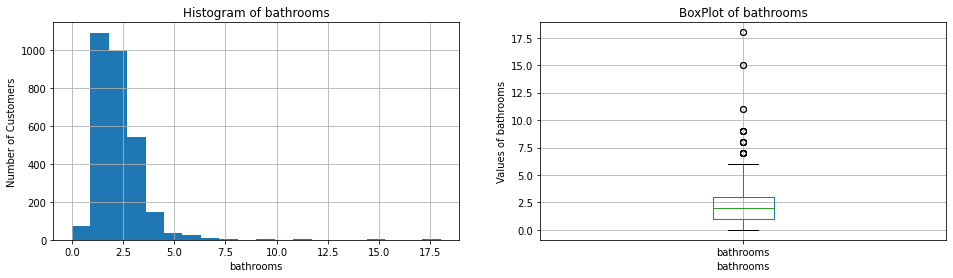

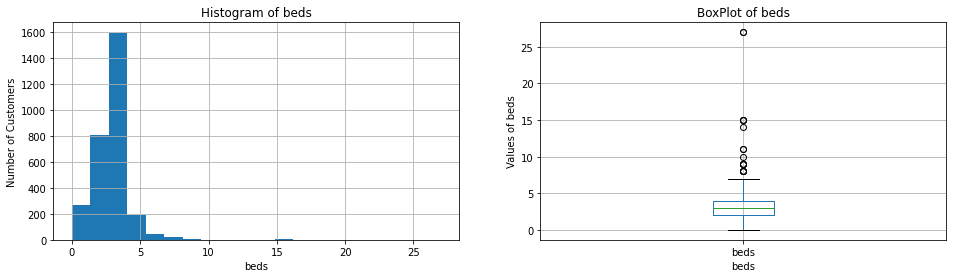

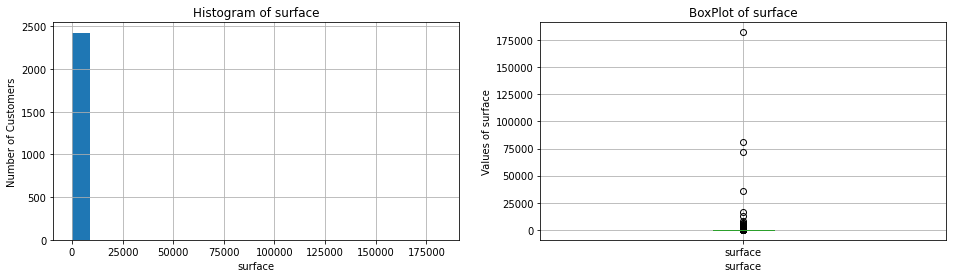

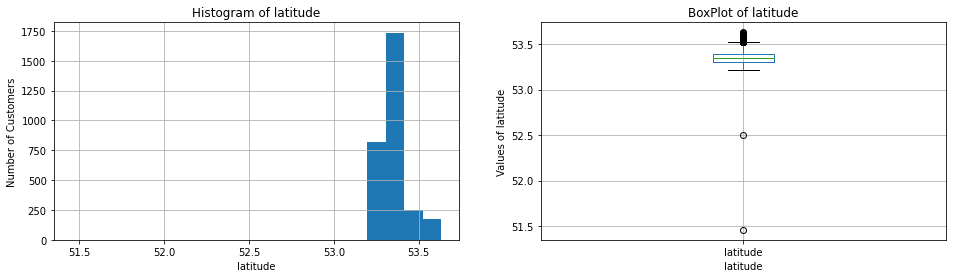

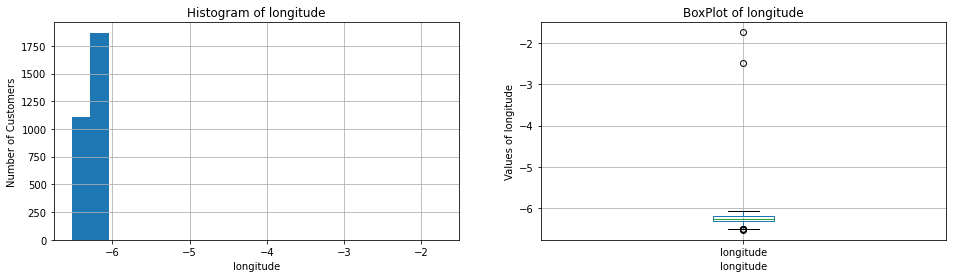

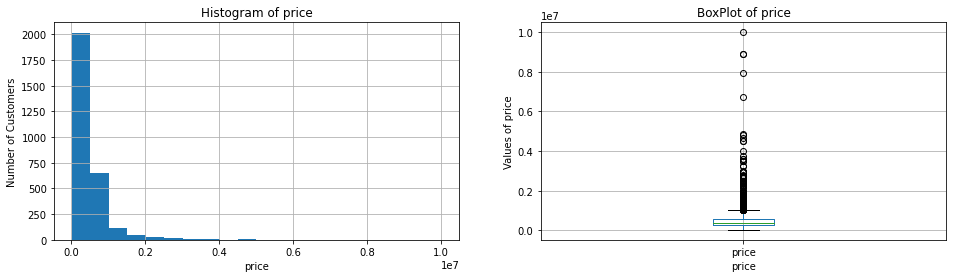

In [33]:
# Plot numerical data distributions to check for outliers
for sNumericalFeature in dCategoricalAndNumericalFeatures['numerical']:
  if sNumericalFeature == 'ad_id':
    pass
  else:
    plotHistogramAndBoxPlot(dftrain,sNumericalFeature)

In [34]:
dftrain['longitude'].describe()

count    2982.000000
mean       -6.257175
std         0.141906
min        -6.521183
25%        -6.314064
50%        -6.252254
75%        -6.196049
max        -1.744995
Name: longitude, dtype: float64

In [35]:
def findOutliers(df):
  """Given a Pandas dataframe, 'df', print an analysis which shows for each column whether or not it contains outliers"""

# Find outliers.
# 1.  Calculate interquartile range

  dfQ1 = df.quantile(0.25)
  dfQ3 = df.quantile(0.75)
  dfIQR = dfQ3 - dfQ1
# Anything which is more than 1.5 times the inter-quartile range below the first quartile or
# above the third quartile is an outlier

  bIsOutlier = ((df < (dfQ1  - (1.5 * dfIQR))) | (df > (dfQ3 + (1.5 * dfIQR))))
# Print column names and a combined value of 'bIsOutlier' for each one.  This will return 'False' against a column
# which contains no outliers and 'True' against columns containing outliers
  print(df[bIsOutlier].any())

In [36]:
findOutliers(dftrain)

ad_id                  True
bathrooms              True
beds                   True
ber_classification    False
latitude               True
longitude              True
price                  True
property_category     False
property_type         False
surface                True
dtype: bool


In [37]:
dftrain.describe()

,ad_id,bathrooms,beds,latitude,longitude,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,9.995000e+06,182108.539008


## Commentary:
Some values for latitude and longitude are inconsistent with a Dublin location: longitude -1.744 is not Dublin; latitude 51.45 is not Dublin!!

In [38]:
dftrain[dftrain.longitude > -6]

,ad_id,bathrooms,beds,ber_classification,latitude,longitude,price,property_category,property_type,surface
767,12270559,1.0,3.0,NaN,52.501856,-1.744995,199000.0,sale,semi-detached,79.0
861,12283542,2.0,4.0,F,51.458439,-2.496219,795000.0,sale,semi-detached,NaN


In [39]:
dftrain[dftrain.latitude < 53]

,ad_id,bathrooms,beds,ber_classification,latitude,longitude,price,property_category,property_type,surface
767,12270559,1.0,3.0,NaN,52.501856,-1.744995,199000.0,sale,semi-detached,79.0
861,12283542,2.0,4.0,F,51.458439,-2.496219,795000.0,sale,semi-detached,NaN


In [40]:
# Drop these
dfIndexBadLongitude = dftrain[dftrain['longitude'] > -6].index
dftrain.drop(dfIndexBadLongitude, inplace=True)

In [41]:
# Check for outliers again
findOutliers(dftrain)


ad_id                  True
bathrooms              True
beds                   True
ber_classification    False
latitude               True
longitude              True
price                  True
property_category     False
property_type         False
surface                True
dtype: bool


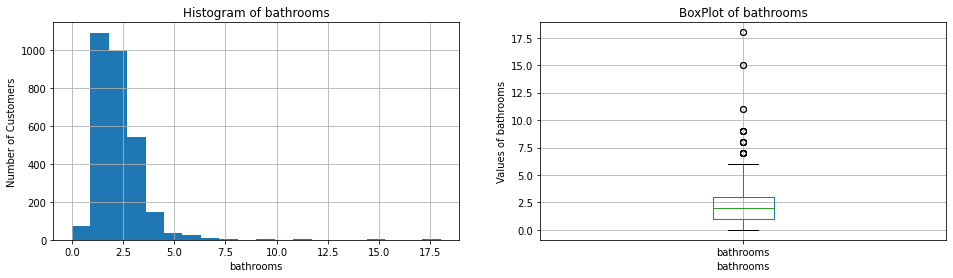

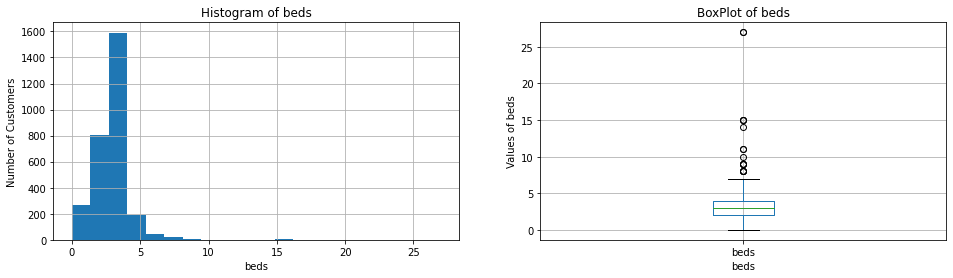

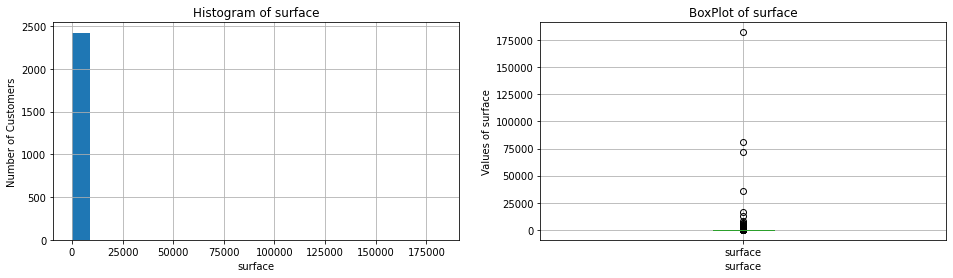

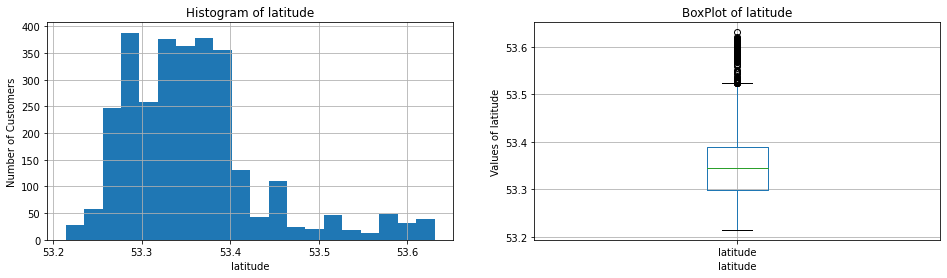

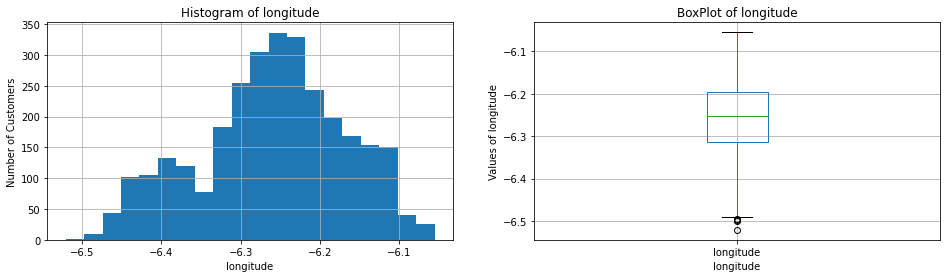

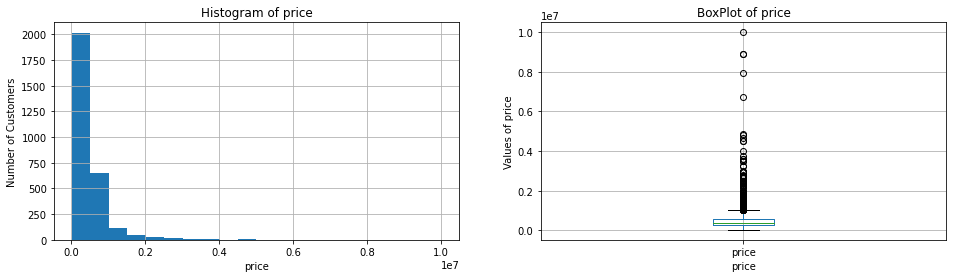

In [42]:
for sNumericalFeature in dCategoricalAndNumericalFeatures['numerical']:
  if sNumericalFeature == 'ad_id':
    pass
  else:
    plotHistogramAndBoxPlot(dftrain,sNumericalFeature)

In [43]:
dftrain.isna().sum()

ad_id                   0
bathrooms              51
beds                   51
ber_classification    676
latitude                0
longitude               0
price                  90
property_category       0
property_type          51
surface               550
dtype: int64

In [44]:
# Drop any row with a non-existent price entry - this is the label in our model
dftrain.dropna(subset=['price'], axis=0, inplace=True) # axis=0 is pedantic, but here to emphasise that we are removing rows

In [45]:
# Drop the 51 'n/a' 'beds' entries
dftrain.dropna(subset=['beds'], axis=0, inplace=True)
# 

In [46]:
dftrain.isna().sum()

ad_id                   0
bathrooms               0
beds                    0
ber_classification    607
latitude                0
longitude               0
price                   0
property_category       0
property_type           0
surface               489
dtype: int64

In [47]:
# Map BER categories to numbers
dBERClassificationMap = {
    "A1": 1,
    "A2": 2,
    "A3": 3,
    "B1": 4,
    "B2": 5,
    "B3": 6,
    "C1": 7,
    "C2": 8,
    "C3": 9,
    "D1": 10,
    "D2": 11,
    "E1": 12,
    "E2": 13,
    "F": 14,
    "G": 15,
    "SINo666of2006exempt" : 16
}
dftrain['ber_classification'] = dftrain['ber_classification'].replace(dBERClassificationMap)
dftest['ber_classification'] = dftest['ber_classification'].replace(dBERClassificationMap)

In [48]:
dftrain['ber_classification'].mean()

9.883048620236531

In [49]:
dftest['ber_classification'].mean()

9.885135135135135

In [50]:
# Replace 'N/A' values in ber_classification with mean, which is approx 10, i.e D1
dftrain['ber_classification'].fillna(10, inplace=True)
dftest['ber_classification'].fillna(10, inplace=True)

In [51]:
# For 'surface' fill with median value
dftrain['surface'].fillna(dftrain['surface'].median(), inplace=True)
dftest['surface'].fillna(dftest['surface'].median(), inplace=True)

In [52]:
dPropertyTypeMapper = {
    'apartment': 1,
    'semi-detached' : 2,
    'terraced' : 3,
    'detached' : 4,
    'end-of-terrace': 5,
    'bungalow': 6,
    'duplex' : 7,
    'site': 8,
    'townhouse': 9,
    'studio': 10}
dftrain['property_type'] = dftrain['property_type'].replace(dPropertyTypeMapper)
dftest['property_type']  = dftest['property_type'].replace(dPropertyTypeMapper)

In [53]:
dftrain['property_type'].value_counts()

1     756
2     747
3     549
4     385
5     235
6      80
7      60
8      48
9      27
10      3
Name: property_type, dtype: int64

In [54]:
dftrain = pd.get_dummies(dftrain, columns=['property_category'], drop_first=True)

In [55]:
dftrain.isna().sum()

ad_id                     0
bathrooms                 0
beds                      0
ber_classification        0
latitude                  0
longitude                 0
price                     0
property_type             0
surface                   0
property_category_sale    0
dtype: int64

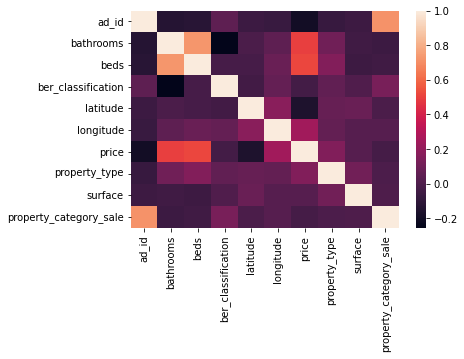

In [56]:
sns.heatmap(dftrain.corr())


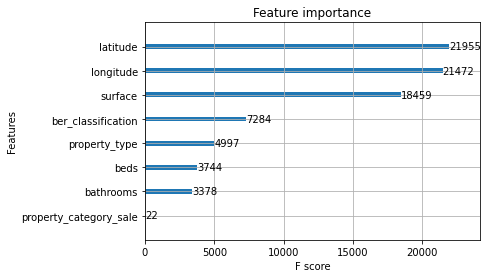

In [57]:
# Try feature selection using XGBoost - see https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

dfTrainCopy = dftrain.copy()
dfTrainNoAdId = dfTrainCopy.drop('ad_id', axis=1)
# For train/test split, 'price' is our label, so drop this when assigning X
X = dfTrainNoAdId.drop('price',axis=1)
y = dfTrainNoAdId['price']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)
oModel = XGBClassifier()
oModel.fit(X_train, y_train)
# plot feature importance
plot_importance(oModel)
plt.show()

# PIECEWISE REGRESSION

## Full Model

In [58]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = ['latitude','longitude','surface','price']
# dropna: remove missing values
df_subset_train = dftrain[featrain].dropna(axis=0)

featest = ['latitude','longitude','surface']
df_subset_test  =  dftest[featest].dropna(axis=0)

# cost
dfcost = dfcost[dfcost.index.isin(df_subset_test.index)]

In [59]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = dfcost.Expected.values

In [60]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [61]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 3,824.4


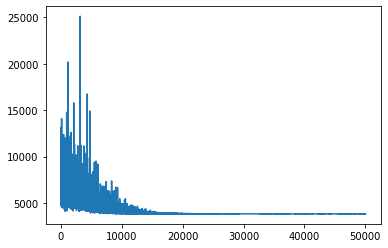

In [62]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [63]:
# samples from the posterior
posterior = approximation.sample(5000)

In [64]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  263030.7371033768
MAPE =  0.3929528110144696


## Clustering

### Full Model

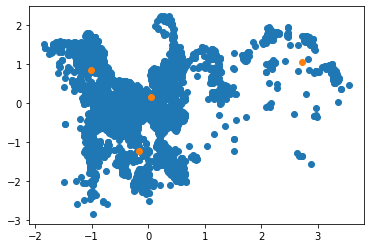

In [65]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
# clustering by features latitude (feature 0) and longitude (feature 1)
ind=[0,1]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

### Clusters

In [66]:
# train clusters
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))


{0: 492, 1: 198, 2: 580, 3: 1620}

In [67]:
# test clusters
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 95, 1: 43, 2: 74, 3: 288}

In [68]:
# Cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [69]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [70]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [71]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

## Piecewise Model

In [72]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 677.59


In [73]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 309.16


In [74]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 837.37


In [75]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 2,143.7


In [76]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred


##Simulations

### Only Cluster 0

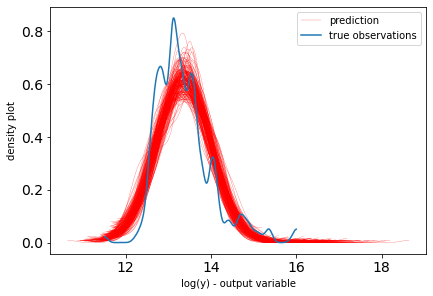

In [77]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 1

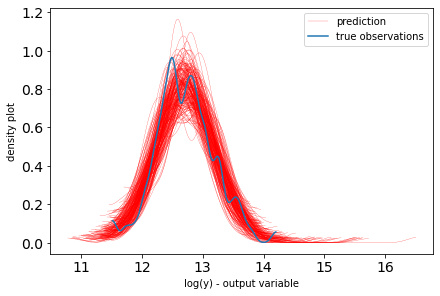

In [78]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 2

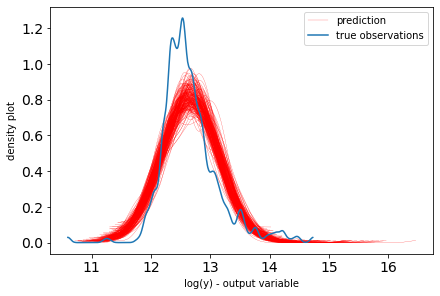

In [79]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

In [80]:
### Only Cluster 3

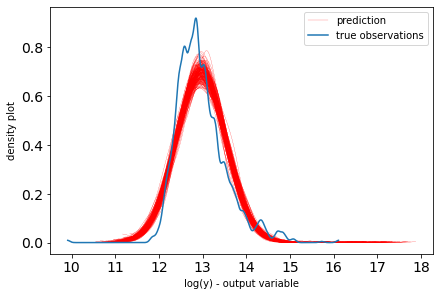

In [81]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

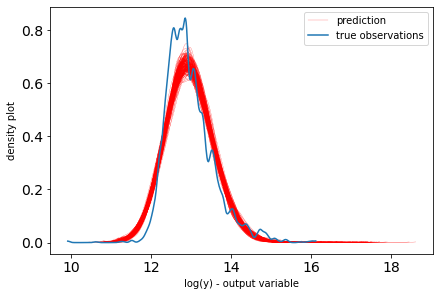

In [82]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [83]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3])])

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 95 , MAE Cluster0= 306319.20071454137
Size Cluster1 43 , MAE Cluster1= 137358.99793829376
Size Cluster2 74 , MAE Cluster2= 165367.44511455818
Size Cluster3 288 , MAE Cluster3= 277239.4730107774
MAE= 254177.84028961856


### PPC on the Test set



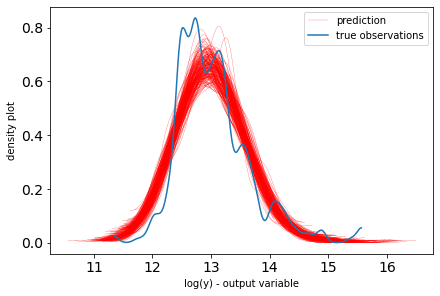

In [84]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# SUMMARY